*<h5 style="text-align: right;">trotss | Internet Engineering</h5>*
<hr style="height: 5px;">

# *<center>Assignment I: Performance of LRC codes </center>*

### **<center>LRC[6,4,2]</center>**
---

In [10]:
import numpy as np
import galois
import os
import re
import random
import string
import matplotlib.pyplot as plt
import datetime

In [20]:
def inicializa():
    if not os.path.exists("./Ficheroentrada.txt"):
        with open("./Ficheroentrada.txt", 'w') as archivo:
            archivo.write('Hola mundo que tal')
        print('Archivo de prueba generado')
    if not os.path.exists('input/'):
        os.makedirs('input/')
        print('Directorio input creado')
    if not os.path.exists('shards/'):
        os.makedirs('shards/')
        print('Directorio shards creado')
    if not os.path.exists('output/'):
        os.makedirs('output/')
        print('Directorio output creado')

    longitudes = [ 10000 + i * (100000 - 10000) // 9 for i in range(8)]
    for i, longitud in enumerate(longitudes):
        with open(f"input/archivo_{i+1}.txt", "w") as f:
            contenido = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(longitud))
            f.write(contenido)
    
    GF = galois.GF(2**8)
    G = GF([
    [1, 0, 0, 0], 
    [1, 1, 0, 0], 
    [0, 1, 0, 0], 
    [0, 0, 1, 0],
    [0, 0, 1, 1], 
    [0, 0, 0, 1]])
    return G, GF, longitudes

In [18]:
def lee_divide(file=0):
    archivo = "./Ficheroentrada.txt" if file == 0 else f"input/archivo_{file}.txt"
    with open(archivo , "rb") as f:
        input_data = list(f.read())
    chunks = []
    for i in range(0, len(input_data), 4):
        chunk = input_data[i:i+4]
        while len(chunk) < 4:
            chunk.append(0)  
        chunks.append(chunk)
    return chunks

In [23]:
def encode(chunks, G, GF):
    shards = [[],[],[],[],[],[]]
    for chunk in chunks:
        data_vec = GF(np.array(chunk, dtype=np.uint8))
        for index, g in enumerate(G):
            codeword = (g @ data_vec) 
            shards[index].append(codeword)
    return shards
    

In [24]:
def escribe(shards, G):
    for i in range(len(G)):
        with open(f"shards/shard{i}.txt", 'w') as f:
            for element in shards[i]:
                f.write(str(element) + ' ' )
    return

In [5]:
def eliminar_shards(indices):
    for i in indices:
        try:
            os.remove(f"shards/shard{i}.txt")
        except FileNotFoundError:
            print(f"Archivo shards/shard{i}.txt no encontrado.")
        except Exception as e:
            print(f"Error al eliminar shards/shard{i}.txt: {e}")
    return

In [7]:
def decode(G,GF, archivo):
    shards = [[],[],[],[],[],[]]
    for i in range(len(G)):
        with open(f"shards/shard{i}.txt", 'r') as f:
            lee = f.read()
            shards[i] = [int(i) for i in lee.split()]  
    dec = []  
    it = [0,2,3,5]
    A = [G[i] for i in it]
    H = GF(A)
    for i in range(len(shards[0])):
        received = [shards[0][i],shards[2][i],shards[3][i],shards[5][i]]
        decoded = (H.T @ GF(np.array(received, dtype=np.uint8)))
        for n in decoded:
            dec.append(int(n))
            
    cadena_bytes = bytes(dec)
    contador = 0
    while cadena_bytes.endswith(b'\x00') and contador < 3:
        cadena_bytes = cadena_bytes[:-1]  
        contador += 1
    if archivo == "./Ficherosalida.txt":
        with open("./Ficherosalida.txt", 'w') as archivo:
            archivo.write(cadena_bytes.decode('utf-8'))
    return

In [8]:
def recover(GF):
    shards = [archivo for archivo in os.listdir('shards/') if archivo.startswith('shard')]
    intactos = []
    for shard in shards:
        coincidencia = re.search(r"shard(\d+)\.txt", shard)
        if coincidencia:
            intactos.append(int(coincidencia.group(1)))
    faltantes = [i for i in range(6) if i not in intactos]
    for i in faltantes:
        if i % 3 == 0:
            recuperación = [i + 1, i + 2]
        elif i % 3 == 1:
            recuperación = [i - 1, i + 1]
        elif i % 3 == 2:
            recuperación = [i - 2, i - 1]
        for j in recuperación:
            if j in faltantes:
                print('Falla imposible de recuperar')

        A = recuperación[0]
        B = recuperación[1]
        with open(f"shards/shard{A}.txt", "r") as f:
            lee = f.read()
            Aa = [GF(c) for c in lee.split()]
        with open(f"shards/shard{B}.txt", "r") as f:
            lee = f.read()
            Bb = [GF(c) for c in lee.split()]
        recuperado = []
        for x in range(len(Aa)):
            recuperado.append(Aa[x] ^ Bb[x])
        with open(f"shards/shard{i}.txt", "w") as f:
            for element in recuperado:
                f.write(str(element) + ' ' )
    return 

<hr style="height: 5px;">

# <center>*Archivo de prueba*

In [26]:
G, GF, longitudes = inicializa()
chunks = lee_divide()
shards = encode(chunks, G, GF)
escribe(shards, G)
eliminar_shards([1,5])
recover(GF)
decode(G, GF, "./Ficherosalida.txt")

<hr style="height: 5px;">

# <center>*Cálculo de métricas de rendimiento temporales*

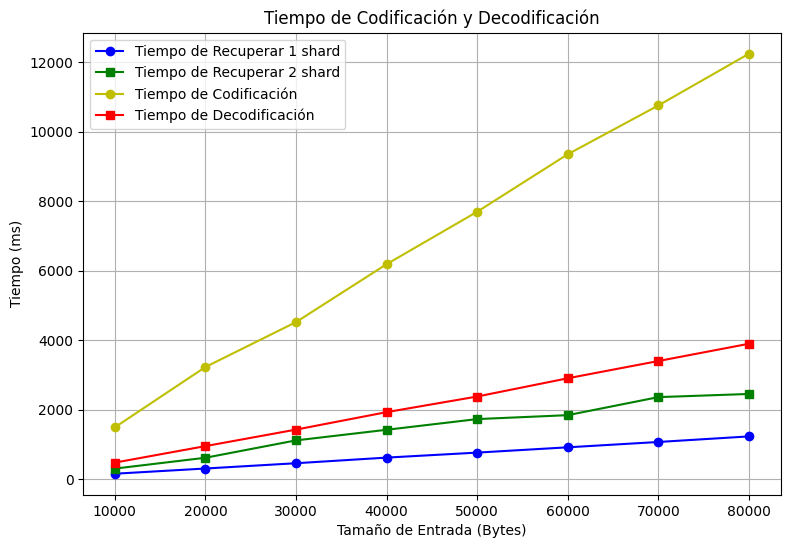

In [25]:
borrado = [[2],[1,4]]
n_shards = [[],[]]
encod = []
decod = []

G, GF, longitudes = inicializa()

for r in range(2):
    for i in range(1,9):
        chunks = lee_divide(i)
        a = datetime.datetime.now()
        shards = encode(chunks, G, GF)
        b = datetime.datetime.now()
        escribe(shards, G)
        eliminar_shards(borrado[r])
        c = datetime.datetime.now()
        recover(GF)
        d = datetime.datetime.now()
        decode(G, GF, 'metricas')
        e = datetime.datetime.now()

        f = b - a # cod
        g = d - c # rec
        h = e - d # decod
        n_shards[r].append((g.seconds * 1000) + (g.microseconds / 1000))
        if r == 0:
            encod.append((f.seconds * 1000) + (f.microseconds / 1000))
            decod.append((h.seconds * 1000) + (h.microseconds / 1000))
        

plt.figure(figsize=(9, 6))
plt.plot(longitudes, n_shards[0], marker='o', linestyle='-', color='b', label='Tiempo de Recuperar 1 shard')
plt.plot(longitudes, n_shards[1], marker='s', linestyle='-', color='g', label='Tiempo de Recuperar 2 shard')
plt.plot(longitudes, encod, marker='o', linestyle='-', color='y', label='Tiempo de Codificación')
plt.plot(longitudes, decod, marker='s', linestyle='-', color='r', label='Tiempo de Decodificación')
plt.xlabel('Tamaño de Entrada (Bytes)')
plt.ylabel('Tiempo (ms)')
plt.title('Tiempo de Codificación y Decodificación')
plt.legend()
plt.grid(True)
plt.savefig("recuperación.png")
plt.show()
# Ejecucción aproximada 4m